<a href="https://colab.research.google.com/github/hy30n80/KERC2022/blob/main/%08Model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 40.0 MB/s 
     |████████████████████████████████| 453 kB 40.7 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from konlpy.tag import Hannanum, Kkma, Komoran, Okt
from gensim.models.word2vec import Word2Vec
from tqdm import tqdm
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_x_path = './drive/MyDrive/KERC2022/KERC22Dataset_PublicTest/train_data.tsv'
train_y_path = './drive/MyDrive/KERC2022/KERC22Dataset_PublicTest/train_labels.csv'

In [ ]:
EMBEDDING_DIM=100
MAXLEN = 30
TRUNCATING = 'post'
PADDING = 'pre'
OOV_TOKEN = '<OOV>'
NUM_WORDS = 15000
SPLIT_SIZE = 0.9

In [ ]:
#우선은 sentences 로만 모델 구성하기 때문에, context 에 대한 null 전처리 나중에 고려
train_data = pd.read_csv(train_x_path, sep='\t')
print(train_data[:5])
print(len(train_data))
print(train_data.isnull().sum())

labels = pd.read_csv(train_y_path)

   sentence_id person                                           sentence  \
0            1     어영  야! 전화 받아. 아무리 바빠도 내전화는 받아야 되는거 아냐? 약속 하나도 못지키는...   
1            2     어영     우리 아무래도 안되겠다. 이게 최선인거 같애. 평생 잊지 않을게. 행복하길 바란다.   
2            3    지구대                          김경사님, 아직 안가셨어요? 시간 다됐을텐데.   
3            4     순경                                         근무중인데 어딜가?   
4            5    지구대    다녀오세요. 이런날은 무조건 가서 축하해주셔야죠. 이순경이 대신 근무선다고 나온대요.   

   scene                                          context  
0  S0104                                              NaN  
1  S0108         포기한듯 탁 일어서는데, 띵동 문자. 후다닥 보는 어영. 기막혀 읽어보는  
2  S0109  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대  
3  S0109  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대  
4  S0109  초조하게 시계보면서 왔다갔다 서성이는 김순경. 순찰차(경차)와서 멈추고 내리는 지구대  
7339
sentence_id       0
person            0
sentence          0
scene             0
context        2017
dtype: int64


In [ ]:
# Stopwords 는 우선 고려하지 않고 실행
hannanum = Hannanum()
kkma = Kkma()
komoran = Komoran()
okt = Okt()

tok_sentences = []
for sen in tqdm(train_data['sentence']):
  tok_sen = okt.morphs(sen)
  tok_sentences.append(tok_sen)

100%|██████████| 7339/7339 [00:28<00:00, 255.63it/s]


문장 최대 길이:  73
문장 평균 길이:  12.137212154244448


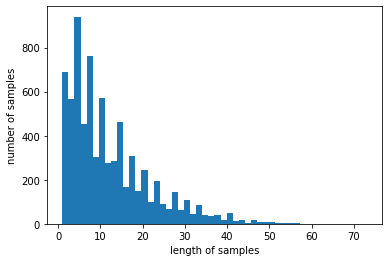

In [ ]:
print('문장 최대 길이: ', max(len(sen) for sen in tok_sentences))
print('문장 평균 길이: ', sum(map(len, tok_sentences))/len(tok_sentences))
plt.hist([len(sen) for sen in tok_sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
"""
model = Word2Vec(sentences = tok_sentences, size=100, window=5, min_count=1, workers=4, sg=0)
model.wv.vectors.shape
"""

'\nmodel = Word2Vec(sentences = tok_sentences, size=100, window=5, min_count=1, workers=4, sg=0)\nmodel.wv.vectors.shape\n'

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def fit_and_seq(train_sentences, oov_token, maxlen, padding, truncating):
  
  tokenizer = Tokenizer(oov_token = oov_token)
  tokenizer.fit_on_texts(train_sentences)
  

  sequences= tokenizer.texts_to_sequences(train_sentences)
  pad_trunc_sequences= pad_sequences(sequences, maxlen=maxlen, padding=padding, truncating=truncating)

  return pad_trunc_sequences, tokenizer

def tokenize_label(labels):

  label_tokenizer = Tokenizer()
  label_tokenizer.fit_on_texts(labels)

  label_seq = label_tokenizer.texts_to_sequences(labels)
  label_seq_np = np.array(label_seq)-1

  return label_seq_np



In [ ]:
train_label_seq = tokenize_label(np.array(labels['label']))

In [ ]:
train_sentence_seq, tokenizer = fit_and_seq(tok_sentences, OOV_TOKEN, MAXLEN, PADDING, TRUNCATING)

In [ ]:
word_index = tokenizer.word_index
print(train_sentence_seq[3])
print(word_index['근무'])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0 533 370  92 482   6   3]
533


In [ ]:
def train_val_split(sentences, labels, training_split):

  train_size = int(len(sentences)*training_split)

  train_sentences = sentences[:train_size]
  train_labels = labels[:train_size]

  val_sentences = sentences[train_size:]
  val_labels = labels[train_size:]

  return train_sentences, train_labels, val_sentences, val_labels

In [ ]:
train_sentences, train_labels, val_sentences, val_labels = train_val_split(train_sentence_seq, train_label_seq, SPLIT_SIZE)

In [ ]:
def create_model(num_words, embedding_dim, maxlen):
  
  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
      tf.keras.layers.GlobalAveragePooling1D(),
      tf.keras.layers.Dense(32, activation= 'relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(16, activation = 'relu'),
      tf.keras.layers.Dense(3, activation = 'softmax')
  ])

  model.compile(loss='sparse_categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])
  
  return model

In [ ]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(train_sentences, train_labels, epochs=30, validation_data = (val_sentences, val_labels) )

Epoch 1/30
207/207 [==============================] - 6s 20ms/step - loss: 0.9493 - accuracy: 0.6017 - val_loss: 0.7395 - val_accuracy: 0.7084
Epoch 2/30
207/207 [==============================] - 4s 19ms/step - loss: 0.8301 - accuracy: 0.6129 - val_loss: 0.6778 - val_accuracy: 0.7057
Epoch 3/30
207/207 [==============================] - 4s 20ms/step - loss: 0.6756 - accuracy: 0.7031 - val_loss: 0.7327 - val_accuracy: 0.6948
Epoch 4/30
207/207 [==============================] - 4s 20ms/step - loss: 0.5202 - accuracy: 0.7755 - val_loss: 0.8415 - val_accuracy: 0.6662
Epoch 5/30
207/207 [==============================] - 4s 20ms/step - loss: 0.4145 - accuracy: 0.8276 - val_loss: 0.9351 - val_accuracy: 0.6022
Epoch 6/30
207/207 [==============================] - 4s 20ms/step - loss: 0.3458 - accuracy: 0.8663 - val_loss: 0.9883 - val_accuracy: 0.6308
Epoch 7/30
207/207 [==============================] - 4s 20ms/step - loss: 0.2833 - accuracy: 0.8921 - val_loss: 1.1097 - val_accuracy: 0.5940